In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.stats import f_oneway

import warnings
warnings.filterwarnings('ignore')

data_path = 'og_data/'

train = pd.read_csv(os.path.join(data_path, 'train.csv'), parse_dates=['date'])
test = pd.read_csv(os.path.join(data_path, 'test.csv'), parse_dates=['date'])

# holidays_events = pd.read_csv(os.path.join(data_path, 'holidays_events.csv'), parse_dates=['date'])
oil = pd.read_csv(os.path.join(data_path, 'oil.csv'), parse_dates=['date'])
stores = pd.read_csv(os.path.join(data_path, 'stores.csv'))
transactions = pd.read_csv(os.path.join(data_path, 'transactions.csv'), parse_dates=['date'])
submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'), index_col='id')

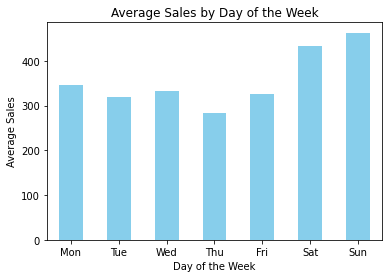

F-statistic: 1506.5585637191425
P-value: 0.0


In [2]:

data = pd.read_csv(os.path.join(data_path, 'train.csv'), parse_dates=['date'])

data['dayofweek'] = data['date'].dt.dayofweek

average_sales = data.groupby('dayofweek')['sales'].mean()

average_sales.plot(kind='bar', color='skyblue')
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.xticks(range(0, 7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()

grouped = data.groupby('dayofweek')['sales']

sales_data = [group for name, group in grouped]

f_stat, p_value = f_oneway(*sales_data)
print('F-statistic:', f_stat)
print('P-value:', p_value)

In [3]:
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(oil['dcoilwtico'].rolling(window=5, min_periods=1, center=True).mean())
oil['dcoilwtico'].fillna(oil['dcoilwtico'].mean(), inplace=True)
oil['date'] = pd.to_datetime(oil['date'])

train_data = train.copy().drop(['onpromotion'], axis=1)
test_data = test.copy().drop(['onpromotion'], axis=1)

train_data['dayofweek'] = data['date'].dt.dayofweek
test_data['dayofweek'] = data['date'].dt.dayofweek

train_data = train_data.merge(oil, on='date', how='left')
test_data = test_data.merge(oil, on='date', how='left')



# Ordinal Encoding for 'family' column
ordinal_encoder = OrdinalEncoder(dtype=int)
train_data[['family']] = ordinal_encoder.fit_transform(train_data[['family']])
test_data[['family']] = ordinal_encoder.transform(test_data[['family']])

num_days_train = train["date"].nunique()
num_stores_train = train["store_nbr"].nunique()
num_families_train = train["family"].nunique()

num_days_test = test["date"].nunique()
num_stores_test = test["store_nbr"].nunique()
num_families_test = test["family"].nunique()

pivoted_train = train_data.pivot(index=['date','dcoilwtico','dayofweek'], columns=['store_nbr', 'family'], values='sales')

train_samples = int(num_days_train * 0.95)
train_samples_df = pivoted_train[:train_samples]
valid_samples_df = pivoted_train[train_samples:]

print("\nFirst 5 rows of the original train data:")
print(train_samples_df.shape)
print(train_samples_df.head())

minmax_scaler = MinMaxScaler()
minmax_scaler.fit(train_samples_df)
scaled_train_samples = minmax_scaler.transform(train_samples_df)
scaled_validation_samples = minmax_scaler.transform(valid_samples_df)

print("\nFirst 5 rows of the original train data:")
print(scaled_train_samples.shape)
print(scaled_train_samples)


First 5 rows of the original train data:
(1599, 1782)
store_nbr                          1                                       \
family                            0    1    2       3    4        5    6    
date       dcoilwtico dayofweek                                             
2013-01-01 93.055     1          0.0  0.0  0.0     0.0  0.0    0.000  0.0   
2013-01-02 93.140     2          2.0  0.0  2.0  1091.0  0.0  470.652  0.0   
2013-01-03 92.970     3          3.0  0.0  0.0   919.0  0.0  310.655  0.0   
2013-01-04 93.120     4          3.0  0.0  3.0   953.0  0.0  198.366  0.0   
2013-01-05 NaN        5          5.0  0.0  3.0  1160.0  0.0  301.057  0.0   

store_nbr                                                ...    9           \
family                               7      8        9   ...   23       24   
date       dcoilwtico dayofweek                          ...                 
2013-01-01 93.055     1             0.0    0.0    0.000  ...  0.0    0.000   
2013-01-02 93.14

In [4]:
def split_series(series, n_past, n_future):
    X, y = [], []
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        X.append(series[window_start:past_end, :])
        y.append(series[past_end:future_end, :])
    return np.array(X), np.array(y)

n_past = 16
n_future = 16
n_features = num_stores_train * num_families_train

X_train, y_train = split_series(scaled_train_samples, n_past, n_future)
X_val, y_val = split_series(scaled_validation_samples, n_past, n_future)

model = Sequential()
model.add(layers.LSTM(units=200, return_sequences=True, input_shape=(n_past, n_features)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=300, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=300, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(units=300, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=300, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.TimeDistributed(layers.Dense(n_features)))

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

model.summary()

early_stopping = EarlyStopping(monitor='val_mae', min_delta=0.0001, patience=100, restore_best_weights=True)

EPOCHS = 1000
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, callbacks=[early_stopping], batch_size=512, shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16, 200)           1586400   
                                                                 
 batch_normalization (BatchN  (None, 16, 200)          800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 16, 300)           601200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 300)          1200      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 16, 300)           0

In [5]:
x_test_pred = scaled_validation_samples[-n_past:].reshape((1, n_past, n_features))
scaled_y_predict = model.predict(x_test_pred)

y_predict = pd.DataFrame(minmax_scaler.inverse_transform(scaled_y_predict.reshape((n_future, n_features))), columns=valid_samples_df.columns)

1/1 [==============================] - 2s 2s/step


In [6]:
pivoted_test = test_data.pivot(index=['date','dcoilwtico','dayofweek'], columns=['store_nbr', 'family'], values='id')

for day_ith, day_ith_pred in y_predict.iterrows():
    for n_samples_per_day in range(len(day_ith_pred)):
        sample_id = pivoted_test.iloc[[day_ith], [n_samples_per_day]].values[0][0]
        values = max(0, day_ith_pred.values[n_samples_per_day])
        submission.at[sample_id, 'sales'] = max(0, day_ith_pred.values[n_samples_per_day])

submission.to_csv('submission.csv')
print("\nFirst 5 rows of the data:")
print(submission.head())


First 5 rows of the data:
               sales
id                  
3000888     3.740128
3000889     0.000762
3000890     3.576232
3000891  2870.159424
3000892     0.103825
